In [22]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input, Dropout
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import cv2
import random
import IPython.display as ipd
import librosa
import matplotlib.pyplot as plt

In [23]:
# Load data and preprocess
def load_and_trim_audio(file_path):
    audio, sr = librosa.load(file_path)
    audio, _ = librosa.effects.trim(audio)
    return audio, sr

In [24]:
def load_and_preprocess_data(audio_dir, genres):
    audio_files = []
    labels = []
    for genre in genres:
        for file in os.listdir(f'{audio_dir}/{genre}'):
            audio, sr = load_and_trim_audio(f'{audio_dir}/{genre}/{file}')
            mel_spectrogram = create_mel_spectrogram(audio, sr)
            audio_files.append(mel_spectrogram)
            labels.append(genre)
    return audio_files, labels

In [25]:
def load_image_data(image_dir, genres):
    image_files = []
    labels = []
    for genre in genres:
        genre_dir = os.path.join(image_dir, genre)
        for file in os.listdir(genre_dir):
            if file.endswith('.png'):  # Assuming images are in PNG format
                image_path = os.path.join(genre_dir, file)
                image = cv2.imread(image_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB
                image = cv2.resize(image, (224, 224))  # Resize to match VGG16 input
                image = image / 255.0  # Normalize pixel values
                image_files.append(image)
                labels.append(genre)
    return image_files, labels

In [ ]:
# Load and preprocess data
audio_dir = r'D:\musicdata\Data\genres_original'
genres = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
audio_files, labels = load_and_preprocess_data(audio_dir, genres)

In [27]:
# Load image data
image_dir = 'D:\musicdata\Data\images_original'
image_files, labels = load_image_data(image_dir, genres)

In [28]:
# Convert to numpy array
X = np.array(image_files, dtype=np.float32)  # Ensure float32 data type
y = np.array(labels)

In [30]:
# Convert labels to numerical format
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(labels)

In [31]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [32]:
# Scale features using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.reshape(-1, X_train.shape[1] * X_train.shape[2])).reshape(X_train.shape)
X_test_scaled = scaler.transform(X_test.reshape(-1, X_test.shape[1] * X_test.shape[2])).reshape(X_test.shape)


In [33]:
# Define custom CNN model architecture
input_shape = X_train.shape[1:]
inputs = Input(shape=input_shape)
custom_model = Sequential([
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(256, (3, 3), activation='relu'),
  # Added layer
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),  # Increased neurons
    Dropout(0.2),  # Added dropout for regularization
    Dense(10, activation='softmax')
])

In [34]:
# Compile custom model
custom_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [35]:
# Train custom model
custom_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.0898 - loss: 2.5718 - val_accuracy: 0.1350 - val_loss: 2.2147
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 25s 983ms/step - accuracy: 0.2061 - loss: 2.1330 - val_accuracy: 0.2850 - val_loss: 1.9289
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.3229 - loss: 1.9280 - val_accuracy: 0.3450 - val_loss: 1.9045
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.4137 - loss: 1.6507 - val_accuracy: 0.3950 - val_loss: 1.6775
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.4554 - loss: 1.5235 - val_accuracy: 0.4600 - val_loss: 1.5179
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.4927 - loss: 1.4114 - val_accuracy: 0.4650 - val_loss: 1.4394
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 25s 998ms/step - accuracy: 0.5187 - loss: 1.3558 - val_accuracy: 0.5350 - val_loss: 1.3613
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 25s 998ms/step - accuracy: 0.5982 - loss: 1.1552 - val_accuracy: 0.5800 - 

In [36]:
# Define transfer learning model architecture using InceptionV3
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=X_train.shape[1:])


In [37]:
# Freeze initial layers
for layer in base_model.layers[:10]:
    layer.trainable = False

In [38]:
# Add custom layers on top
x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(10, activation='softmax')(x)
transfer_model = Model(inputs=base_model.input, outputs=x)


In [46]:
# Compile transfer model
transfer_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [47]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)  # If using separate test data
print(y_test.shape)  # If using separate test data

(799, 224, 224, 3)
(799,)
(200, 224, 224, 3)
(200,)


In [48]:
# Train transfer model
transfer_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)

Epoch 1/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 139s 4s/step - accuracy: 0.1308 - loss: 10.1347 - val_accuracy: 0.0938 - val_loss: 38154.3359
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 74s 4s/step - accuracy: 0.1709 - loss: 2.2718 - val_accuracy: 0.0938 - val_loss: 9150.6504
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 71s 4s/step - accuracy: 0.2176 - loss: 2.0518 - val_accuracy: 0.0938 - val_loss: 1516.6228
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 71s 4s/step - accuracy: 0.2663 - loss: 1.9116 - val_accuracy: 0.0938 - val_loss: 92.1659
Epoch 5/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 71s 4s/step - accuracy: 0.3251 - loss: 1.8197 - val_accuracy: 0.0938 - val_loss: 41.7455
Epoch 6/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 72s 4s/step - accuracy: 0.4017 - loss: 1.7849 - val_accuracy: 0.2000 - val_loss: 41.0774
Epoch 7/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 73s 4s/step - accuracy: 0.4310 - loss: 1.5938 - val_accuracy: 0.3625 - val_loss: 4.0037
Epoch 8/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 73s 4s/step - accuracy: 0.5096 - loss: 1.4477 - val_accuracy: 0.2

In [50]:
# Make predictions on test set using custom model
y_pred_custom = custom_model.predict(X_test)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 153ms/step


In [51]:
# Make predictions on test set using transfer model
y_pred_transfer = transfer_model.predict(X_test)


7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 878ms/step


In [52]:
# Convert predictions to probabilities
probabilities_custom = tf.nn.softmax(y_pred_custom).numpy()
probabilities_transfer = tf.nn.softmax(y_pred_transfer).numpy()


In [53]:
# Get genre with highest probability
predicted_genres_custom = np.argmax(probabilities_custom, axis=1)
predicted_genres_transfer = np.argmax(probabilities_transfer, axis=1)


In [54]:
# Evaluate models
accuracy_custom = accuracy_score(y_test, predicted_genres_custom)
accuracy_transfer = accuracy_score(y_test, predicted_genres_transfer)
print(f'Custom model accuracy: {accuracy_custom:.3f}')
print(f'Transfer model accuracy: {accuracy_transfer:.3f}')
print(classification_report(y_test, predicted_genres_custom))
print(classification_report(y_test, predicted_genres_transfer))
print(confusion_matrix(y_test, predicted_genres_custom))
print(confusion_matrix(y_test, predicted_genres_transfer))


Custom model accuracy: 0.610
Transfer model accuracy: 0.565
              precision    recall  f1-score   support

           0       0.79      0.52      0.63        21
           1       0.85      0.92      0.88        12
           2       0.57      0.50      0.53        24
           3       0.42      0.36      0.39        22
           4       0.83      0.33      0.48        15
           5       0.82      0.85      0.84        27
           6       0.74      0.78      0.76        18
           7       0.62      0.53      0.57        19
           8       0.42      0.77      0.55        22
           9       0.46      0.55      0.50        20

    accuracy                           0.61       200
   macro avg       0.65      0.61      0.61       200
weighted avg       0.64      0.61      0.61       200

              precision    recall  f1-score   support

           0       0.43      0.29      0.34        21
           1       1.00      0.92      0.96        12
           2      

In [70]:
def choose_random_sample(X_test, y_test):
    index = np.random.randint(len(X_test))
    sample = X_test[index]
    true_genre = y_test[index]
    return sample, true_genre

In [71]:
# Define function to predict genre of new audio file using custom model
def predict_genre_custom(audio_file):
    audio, sr = load_and_trim_audio(audio_file)
    mel_spectrogram = create_mel_spectrogram(audio, sr)
    mel_spectrogram = mel_spectrogram.reshape((1, mel_spectrogram.shape[0], mel_spectrogram.shape[1], 1))
    mel_spectrogram = scaler.transform(mel_spectrogram.reshape(-1, mel_spectrogram.shape[1] * mel_spectrogram.shape[2])).reshape(mel_spectrogram.shape)
    prediction = custom_model.predict(mel_spectrogram)
    probabilities = tf.nn.softmax(prediction).numpy()
    predicted_genre = np.argmax(probabilities, axis=1)[0]
    return genres[predicted_genre], probabilities[0]


In [72]:
# Define function to predict genre of new audio file using transfer model
def predict_genre_transfer(audio_file):
    audio, sr = load_and_trim_audio(audio_file)
    mel_spectrogram = create_mel_spectrogram(audio, sr)
    mel_spectrogram = mel_spectrogram.reshape((1, mel_spectrogram.shape[0], mel_spectrogram.shape[1], 1))
    mel_spectrogram = scaler.transform(mel_spectrogram.reshape(-1, mel_spectrogram.shape[1] * mel_spectrogram.shape[2])).reshape(mel_spectrogram.shape)
    prediction = transfer_model.predict(mel_spectrogram)
    probabilities = tf.nn.softmax(prediction).numpy()
    predicted_genre = np.argmax(probabilities, axis=1)[0]
    return genres[predicted_genre], probabilities[0]


In [73]:
def predict_and_display(model, sample):
    prediction = model.predict(np.expand_dims(sample, axis=0))
    probabilities = tf.nn.softmax(prediction).numpy()[0]
    predicted_genre = np.argmax(probabilities)
    return predicted_genre, probabilities

In [75]:
def display_mel_spectrogram(audio_file_path):
    audio, sr = librosa.load(audio_file_path)
    mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=128)
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(librosa.power_to_db(mel_spectrogram, ref=np.max), y_axis='mel', x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel Spectrogram')
    plt.tight_layout() 
    plt.show()

In [76]:
def play_audio(audio_file_path):
    audio = AudioSegment.from_file(audio_file_path)
    ipd.Audio(audio.raw_data, rate=audio.frame_rate)

In [77]:
def main():
    while True:
        choice = input("Choose: 1. Random sample, 2. Insert audio file, 3. Insert Mel Spectrogram image: ")
        if choice == "1":
            sample, true_genre = choose_random_sample(X_test, y_test)
            predicted_genre_custom, probabilities_custom = predict_and_display(custom_model, sample)
            predicted_genre_transfer, probabilities_transfer = predict_and_display(transfer_model, sample)

            print(f"True genre: {label_encoder.inverse_transform([true_genre])[0]}")
            print(f"Custom model predicted genre: {label_encoder.inverse_transform([predicted_genre_custom])[0]}")
            print(f"Custom model probabilities: {probabilities_custom}")
            print(f"Transfer model predicted genre: {label_encoder.inverse_transform([predicted_genre_transfer])[0]}")
            print(f"Transfer model probabilities: {probabilities_transfer}")

            audio_file_path = f"D:\\musicdata\\Data\\genres_original\\{label_encoder.inverse_transform([true_genre])[0]}\\{label_encoder.inverse_transform([true_genre])[0]}.00000.wav"  # Replace with appropriate file path logic
            display_mel_spectrogram(audio_file_path)
            play_audio(audio_file_path)

        elif choice == "2":
            audio_file = input("Enter audio file path: ")
            try:
                audio, sr = librosa.load(audio_file)
                mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=128)
                mel_spectrogram = mel_spectrogram.reshape((1, mel_spectrogram.shape[0], mel_spectrogram.shape[1], 1))
                mel_spectrogram = scaler.transform(mel_spectrogram.reshape(-1, mel_spectrogram.shape[1] * mel_spectrogram.shape[2])).reshape(mel_spectrogram.shape)

                prediction_custom = custom_model.predict(mel_spectrogram)
                probabilities_custom = tf.nn.softmax(prediction_custom).numpy()[0]
                predicted_genre_custom = np.argmax(probabilities_custom)

                prediction_transfer = transfer_model.predict(mel_spectrogram)
                probabilities_transfer = tf.nn.softmax(prediction_transfer).numpy()[0]
                predicted_genre_transfer = np.argmax(probabilities_transfer)

                print(f"Custom model predicted genre: {label_encoder.inverse_transform([predicted_genre_custom])[0]}")
                print(f"Custom model probabilities: {probabilities_custom}")
                print(f"Transfer model predicted genre: {label_encoder.inverse_transform([predicted_genre_transfer])[0]}")
                print(f"Transfer model probabilities: {probabilities_transfer}")

                display_mel_spectrogram(audio_file)
                play_audio(audio_file)

            except Exception as e:
                print(f"Error processing audio file: {e}")

        elif choice == "3":
            image_file = input("Enter image file path: ")
            try:
                image = cv2.imread(image_file)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, (224, 224))
                image = image / 255.0
                image = np.expand_dims(image, axis=0) 


                prediction_custom = custom_model.predict(image)
                probabilities_custom = tf.nn.softmax(prediction_custom).numpy()[0]
                predicted_genre_custom = np.argmax(probabilities_custom)

                prediction_transfer = transfer_model.predict(image)
                probabilities_transfer = tf.nn.softmax(prediction_transfer).numpy()[0]
                predicted_genre_transfer = np.argmax(probabilities_transfer)

                print(f"Custom model predicted genre: {label_encoder.inverse_transform([predicted_genre_custom])[0]}")
                print(f"Custom model probabilities: {probabilities_custom}")
                print(f"Transfer model predicted genre: {label_encoder.inverse_transform([predicted_genre_transfer])[0]}")
                print(f"Transfer model probabilities: {probabilities_transfer}")

                audio_file_path = image_file.replace('.png', '.wav')  # Replace with appropriate logic
                display_mel_spectrogram(audio_file_path)
                play_audio(audio_file_path)

            except Exception as e:
                print(f"Error processing image: {e}")

        else:
            print("Invalid choice. Please choose 1, 2, or 3.")

        continue_loop = input("Do you want to continue? (y/n): ")
        if continue_loop.lower() != "y":
            break
            
            

Choose: 1. Random sample, 2. Insert audio file, 3. Insert Mel Spectrogram image: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
True genre: country
Custom model predicted genre: country
Custom model probabilities: [0.08695171 0.0864581  0.21359992 0.08646289 0.08644355 0.09103036
 0.08644518 0.08654475 0.08671238 0.08935115]
Transfer model predicted genre: country
Transfer model probabilities: [0.08701063 0.08698052 0.20361027 0.08702081 0.08695621 0.0870153
 0.08696233 0.08697917 0.08763023 0.09983446]


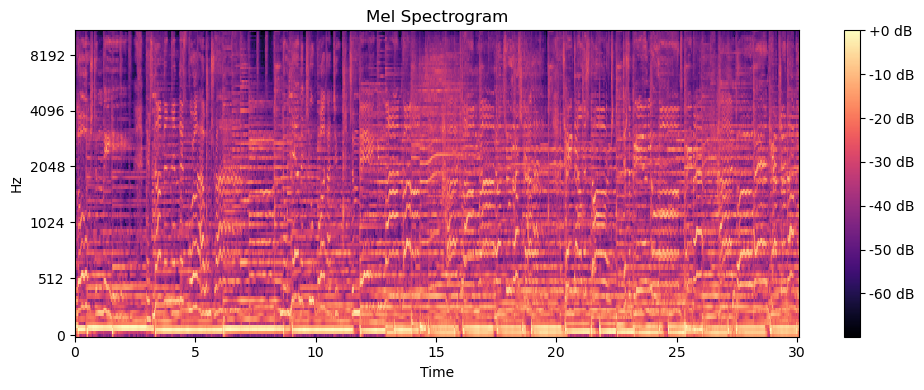

In [ ]:
if __name__ == "__main__":
    main()